In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [14]:
device = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")

In [15]:
batch_size = 32
epochs = 10

In [18]:
train_dataset = datasets.MNIST(root = "../data/MNIST",
                              train = True,
                              download = True,
                              transform = transforms.ToTensor())

test_dataset = datasets.MNIST(root = "../data/MNIST",
                             train = False,
                             download = True,
                             transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size= batch_size,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = batch_size,
                                          shuffle = False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████| 9912422/9912422 [00:03<00:00, 2587373.71it/s]


Extracting ../data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████| 28881/28881 [00:00<00:00, 144969.56it/s]


Extracting ../data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████| 1648877/1648877 [00:01<00:00, 1499652.71it/s]


Extracting ../data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████| 4542/4542 [00:00<00:00, 1061665.67it/s]

Extracting ../data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw



In [20]:
for x_train, y_train in train_loader:
    print(f'x_train: {x_train.size()} type: {x_train.type()}')
    print(f'y_train: {y_train.size()} type: {y_train.type()}')
    break

x_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


In [21]:
print(len(train_loader), len(train_dataset))

1875 60000


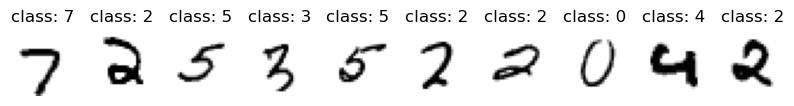

In [28]:
pltsize = 1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(x_train[i, :, :, :].numpy().reshape(28, 28), cmap="gray_r")
    plt.title('class: ' + str(y_train[i].item()))

In [30]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x

In [31]:
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [35]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print(f'train epoch: {epoch} [{batch_idx*len(image)}/{len(train_loader.dataset)} ({100.*batch_idx/len(train_loader):.0f}%)]\ttrain loss: {loss.item():.6f}')

In [39]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(device)
            label = label.to(device)
            output = model(image)
            test_loss = criterion(output, label).item()
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= (len(test_loader.dataset)/batch_size)
    test_accuracy = 100. * correct/len(test_loader.dataset)
    return test_loss, test_accuracy
            

In [40]:
for epoch in range(1, epochs+1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print(f'\n[epoch: {epoch}], \ttest loss: {test_loss:.4f}, \ttest accuracy: {test_accuracy:.4f}')

train epoch: 1 [0/60000 (0%)]	train loss: 2.240489
train epoch: 1 [6400/60000 (11%)]	train loss: 2.186357
train epoch: 1 [12800/60000 (21%)]	train loss: 2.224921
train epoch: 1 [19200/60000 (32%)]	train loss: 2.077679
train epoch: 1 [25600/60000 (43%)]	train loss: 1.983721
train epoch: 1 [32000/60000 (53%)]	train loss: 2.003875
train epoch: 1 [38400/60000 (64%)]	train loss: 1.712066
train epoch: 1 [44800/60000 (75%)]	train loss: 1.466325
train epoch: 1 [51200/60000 (85%)]	train loss: 1.395115
train epoch: 1 [57600/60000 (96%)]	train loss: 1.517393

[epoch: 1], 	test loss: 0.0037, 	test accuracy: 61.1700
train epoch: 2 [0/60000 (0%)]	train loss: 1.162384
train epoch: 2 [6400/60000 (11%)]	train loss: 1.133830
train epoch: 2 [12800/60000 (21%)]	train loss: 0.986532
train epoch: 2 [19200/60000 (32%)]	train loss: 1.152238
train epoch: 2 [25600/60000 (43%)]	train loss: 1.062699
train epoch: 2 [32000/60000 (53%)]	train loss: 1.136755
train epoch: 2 [38400/60000 (64%)]	train loss: 0.680738
tra